**In this kernel, the following is what I will be doing:**

    1. Understand the problem: We will look at each variable and do a philosophical analysis about their 
       meaning and importance for this problem
    2. Univariable study. We'll just focus on the dependent variable ('SalePrice') and try to know a 
       little bit more about it.
    3. Multivariate study. We'll try to understand how the dependent variable and independent variables relate.
    4. Basic cleaning. We'll clean the dataset and handle the missing data, outliers and categorical variables.
    5. Test assumptions. We'll check if our data meets the assumptions required by most multivariate techniques.

**Import Packages**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import utils

In [2]:
%matplotlib inline

### Import Data

In [3]:
def wrangle_data(data_path):
    """Given a data - stored in a particular file-path - import
    and manipulate data set for easier analysis
    
    Parameters:
    -----------
    data_path : str
        File path to the data source
        
    Returns:
    --------
    df : pd.DataFrame
        A pandas DataFrame
    """
    
    # Import data (from csv file)
    df = pd.read_csv(data_path)
    
    
    return df

In [4]:
df = wrangle_data("data/train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


    How big is the data we are working with? How many observations and features (variables)
    are in the dataset?
    * 1,460 Observations
    * 81 features (variables) 🤔 (How am I going to explore all these features?)

In [5]:
df.shape

(1460, 81)

    What features (attributes) do we have? Are there any missing values?
    What about their data-types?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

    In order to understand our data, we will look at each variable and try to understand its meaning
    and relevance to this problem.
    
    In order to have some discipline in my analysis, I've adopted the idea of creating a spreadsheet
    with the following columns:
    
    1. Variable: Variable name
    2. Type: Variable's type; either `numerical` - int, float or `categorical` - for categorical values
    3. Segment: Identification of the variable's segment. We define three possible segments: building, 
       space or location.
    4. Expectation: Our expectation about the variable influence in `SalePrice.` We can define a categorical
       scale of `High`, `Medium` or `Low`
    5. Conclusion: Our conclusions about the importance of the variable, after we give a quick look at the
       data. We can define a categorical scale of `High`, `Medium` or `Low`.
    6. Comments: Any general comments

Analyst found here - [Spreadsheet](https://docs.google.com/spreadsheets/d/1HXOq9GMguCRamvw5YH8CQJececkYsrNYrpygL_pMJ3M/edit?usp=sharing)

    After a subjective and research analysis of each variable's relevance to `SalePrice`,
    I ended up with the following features:

|Feature|Expectation|Comments|
|-------|-----------|-------|
|MSZoning|High|We'd expect the zoning classification to incluenece the price of a house. E.g. With all otherfactors constant, a home in commercial zoning would be priced differently from that in industrail zoning.|
|Neighborhood|High|Definitely, neighborhood affects the price of a house|
|OverallQual|High|Overall material and finish of a house matters in pricing|
|OverallCond|High|Overall condition matters in pricing too|
|1stFlrSF|High|First floor area basically tells us how big the house is in surface area, therefore, it matters|
|2ndFlrSF|High|Same as first floor area|
|GrLivArea|High|Same as the 1stFlrSF and 2ndFlrSF|
|HouseStyle|Medium|We'd expect a different in pricing between 1Story and 2Story building|
|TotBsmtSF|Medium|With all other factors constant, a house with a bigger basement would be more expensive|
|Bedroom|Medium|For obvious reasons, this matters|
|GarageCars|Medium|A house with a garage that can have more cars might be pricy|
|GarageArea|Medium|The bigger the garage area, the more cars can pack in it. There might be multi-collinearity here|
|PoolArea|Medium|The presense of a swimming pool hicks the house price|
|MiscFeature|Medium|Depending on the Misc Feature, the price might be influence or not|

### Explore

    First things first, we will perform `Univariate Analysis` to understand the dependent variable, `SalePrice`;
    we want to understand the price range, as well as the central measures of tendency (min, mean, max prices).
    We will want to understand the frequency distribution, how spread the prices are, etc.

**SalePrice**

In [7]:
sale_price = df['SalePrice']

# Min, Max, Median Price
sale_price.aggregate(['min', 'mean', 'median', 'max']).to_frame()

,SalePrice
min,34900.00000
mean,180921.19589
median,163000.00000
max,755000.00000


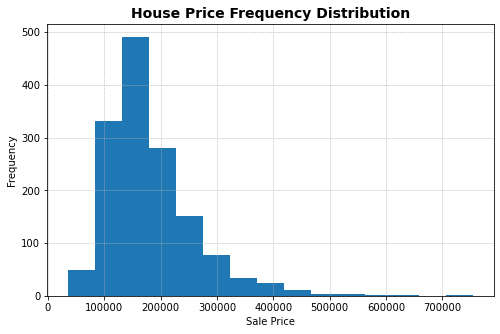

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram
sale_price.plot(kind='hist', bins=15)

# Title Properties
fontdict = {"fontsize": 14, "fontweight": "bold"}

# Labels
plt.title("House Price Frequency Distribution", fontdict=fontdict)
plt.xlabel("Sale Price")
plt.ylabel("Frequency")

# Add vertical lines
plt.grid(linestyle="--", linewidth=0.5)

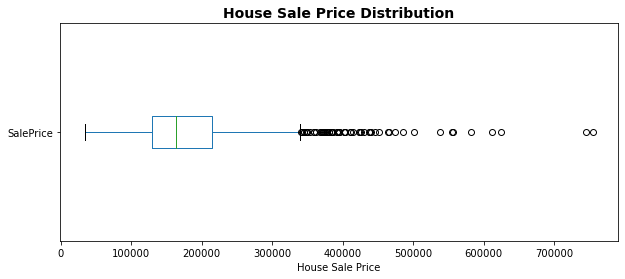

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

# Boxplot
sale_price.plot(kind='box', vert=False)

# Labels
plt.title("House Sale Price Distribution", fontdict=fontdict)
plt.xlabel("House Sale Price");

In [10]:
print("Skewness:", round(sale_price.skew(), 2))
print("Kurtosis:", round(sale_price.kurt(), 2))

Skewness: 1.88
Kurtosis: 6.54


    Summary:
    
    * `SalePrice` is not normally distributed
    * It is skewed towards the right; there are houses with higher sale values present in our data;
      how will we deal with the outlier house prices present in the data ?🤔
    
    * 75% of houses where sold for less than ~USD225_000
    * 50% of houses where sold for a price between USD125_000 and USD225_000
    
    * A small number of houses were sold above USD700,000 
    

**SalePrice vs TotalBsmtSF**

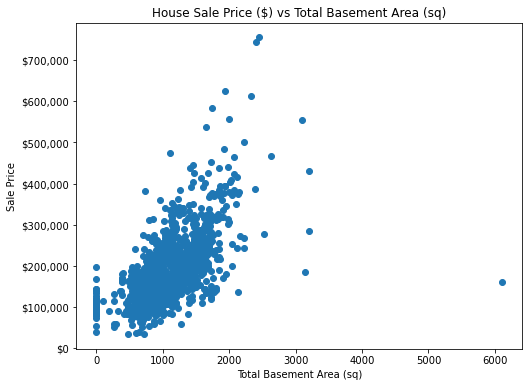

In [12]:
utils.plot_scatter_plot(
    x=df['TotalBsmtSF'], 
    y=sale_price, 
    title="House Sale Price ($) vs Total Basement Area (sq)",
    xlabel="Total Basement Area (sq)",
    ylabel="Sale Price"
)m

In [16]:
print("Sale Price vs TotalBsmtSF Correlation:", round(sale_price.corr(df['TotalBsmtSF']), 2))

Sale Price vs TotalBsmtSF Correlation: 0.61


    Summary
    
    * A positive linear-relationship exists between sale price (USD) and total basement area (sq); As the total
    basement area increases, so does the house sale price. 
    * We observe one house whose total basement area was higher than the rest, but had a selling price close to
    USD200,000

**Sale Price vs 1stFlrSF**

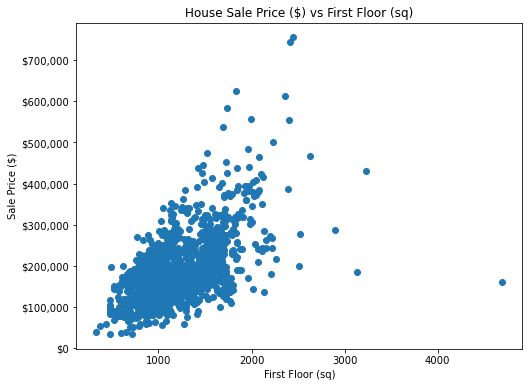

In [18]:
utils.plot_scatter_plot(
    x=df['1stFlrSF'],
    y=sale_price,
    title="House Sale Price ($) vs First Floor (sq)",
    xlabel="First Floor (sq)",
    ylabel="Sale Price ($)"
)

In [20]:
print("Sale Price vs 1stFlrSF Correlation:", round(sale_price.corr(df['1stFlrSF']), 2))

Sale Price vs 1stFlrSF Correlation: 0.61


    Summary
    
    * A positive linear-relationship exists between sale price and first floor (sq); the more first floor
    - in square feet - the more the house sale price.
    * We observe another house whose first floor (sq) was outlier and cost ~USD200,000. Is it the same house
    seen in the previous analysis?

In [24]:
df[df['1stFlrSF'] > 4000][['Id', '1stFlrSF', 'TotalBsmtSF']]

,Id,1stFlrSF,TotalBsmtSF
1298,1299,4692,6110


    * Yep. Is's the same house

**Sale Price vs 2stFlrSF**

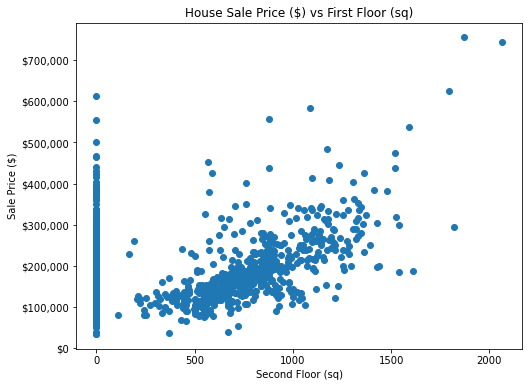

In [26]:
utils.plot_scatter_plot(
    x=df['2ndFlrSF'],
    y=sale_price,
    title="House Sale Price ($) vs First Floor (sq)",
    xlabel="Second Floor (sq)",
    ylabel="Sale Price ($)"
)

In [27]:
print("Sale Price vs 2ndFlrSF Correlation:", round(sale_price.corr(df['2ndFlrSF']), 2))

Sale Price vs 2ndFlrSF Correlation: 0.32


    Summary:
    
    * The scattter plot shows a positive linear-relationship between sale price and second floor (sq); 
    as the second floor area increases, so does the house selling price.
    * The correlation is at 0.32
    * We observe a number of houses whose second floor area (sq) is zero; perhaps these houses didn't have
    a second floor.

In [32]:
# Inspect Houses with a value of 0 on 2ndFlrSF
df[df['2ndFlrSF'] == 0].shape

(829, 81)